In [26]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, GradientDescent, ADAM
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

# Classification

In [2]:
num_inputs = 2 # num of features (p)
num_samples = 20 # num of instances (n)

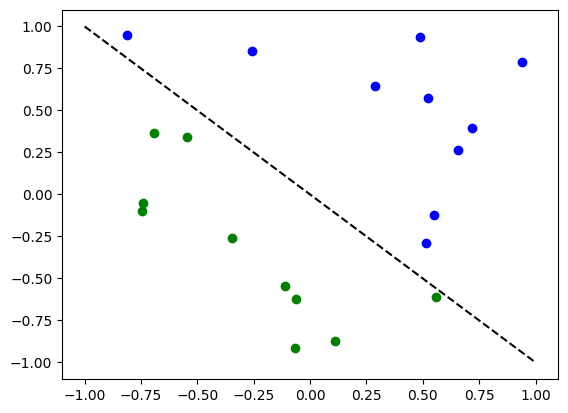

In [3]:
# the design matrix X is of shape (20, 2)
# We choose the values of the features in [1, -1[
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1

# the target y is +1 (top right) or -1 (buttom left)
y01 =1 * (np.sum(X, axis=1) >= 0)
y = 2 * y01 - 1
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

# we plot the data
for x_i, y_i in zip(X, y):
    if y_i == 1:
        plt.plot(x_i[0], x_i[1], "bo")
    else:
        plt.plot(x_i[0], x_i[1], "go")

# we plot the line
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


- with **EstimatorQNN**

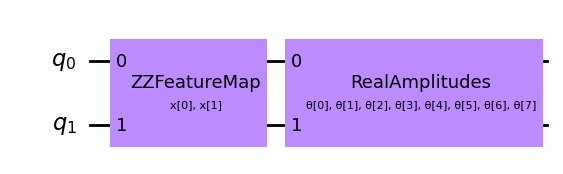

In [ ]:
# we use default ZZFeatureMap feature map and RealAmplitudes ansatz
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

In [7]:
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()
estimator_qnn = EstimatorQNN(
    circuit=qc, 
    estimator=estimator
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [14]:
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[-0.34862631]])

In [15]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [31]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

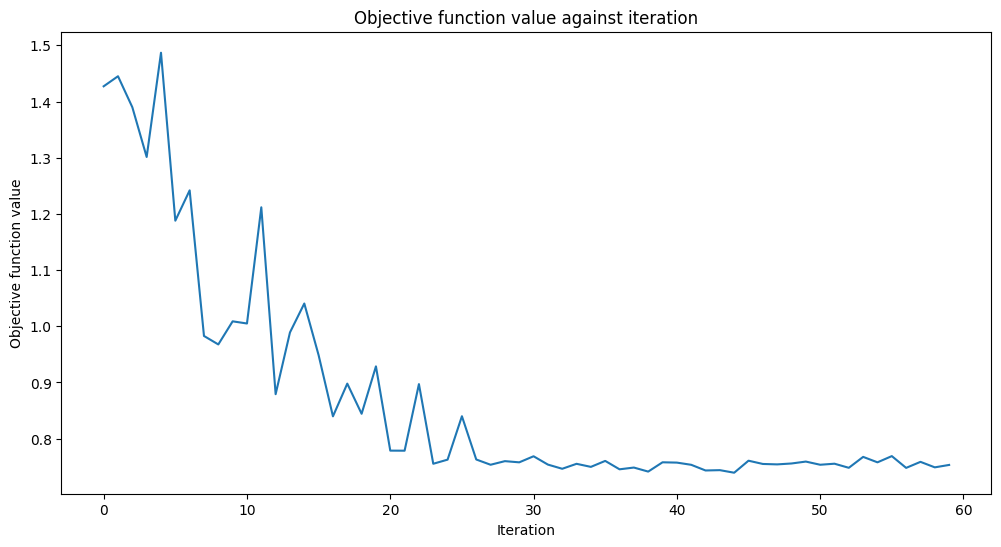

0.75

In [32]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

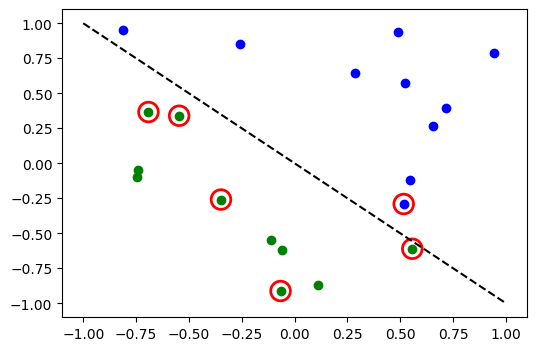

In [24]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [25]:
estimator_classifier.weights

array([-0.03104809,  0.29394173, -0.40441475,  1.18414996,  0.72478926,
        0.3103636 , -0.02573059,  1.35139058])

- with **Variational QC** 

In [33]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

In [34]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


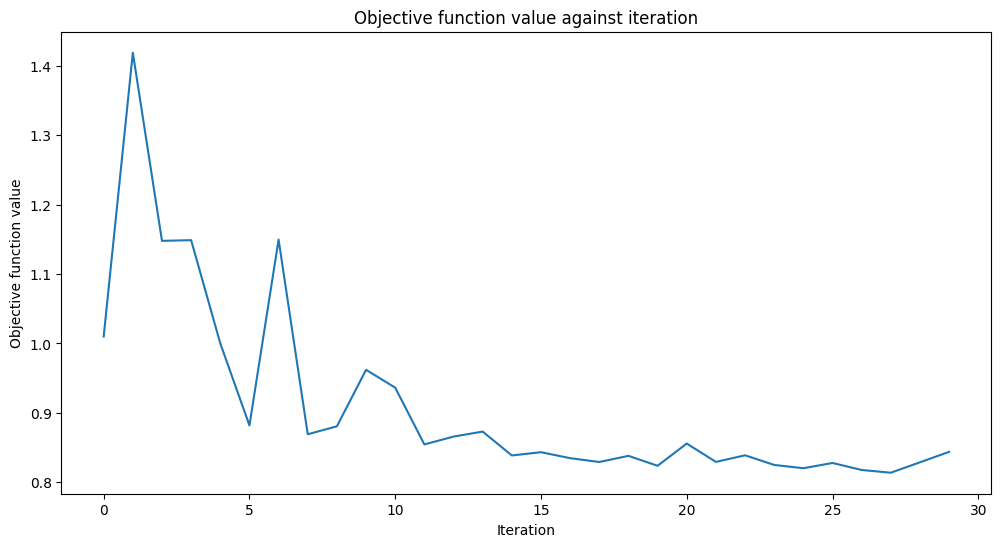

0.7

In [35]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

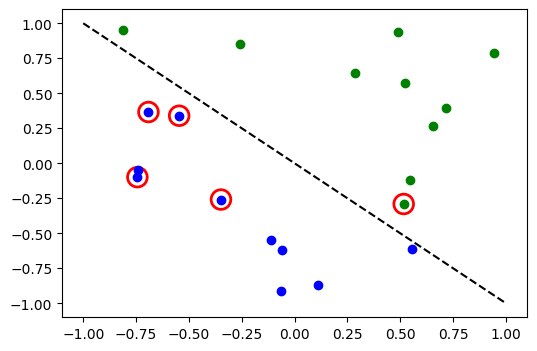

In [36]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()